In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('uk_covid.csv', header=0)
df.drop(['total_cases','new_cases','total_deaths','new_deaths','total_vaccinations',
         'new_vaccinations', 'stringency_index','new_tests','total_tests','positive_rate',
         'tests_per_case','people_vaccinated','people_fully_vaccinated'], axis=1, inplace= True)
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

#one-hot encoding
df = pd.get_dummies(df, columns=['stay_home_requirements','facial_coverings','school_closures',
                                 'workplace_closures','cancel_public_events','restriction_gatherings'])

target = df['reproduction_rate'].to_numpy()
feature = df.drop(['date','reproduction_rate'], axis=1).to_numpy()

## 將時間資料依照時間間隔打包，打包完才做訓練集與測試集分割

In [3]:
train_size = 0.8
timestep = 25
X = []
for step in range(feature.shape[0] - timestep):
    X.append(feature[step:(step+timestep), :])

Y = target[timestep:]

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size = train_size, random_state = 1)

train_X = np.array(train_X)
test_X = np.array(test_X)
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(517, 25, 21) (130, 25, 21) (517,) (130,)


# 使用全連接層作為神經網路主要架構

因為每個batch的是二維的資料，但是神經網路只能匯入一維的資料，因此要先將二維的輸入攤平，使用 Flatten()

神經網路的activation function隨意定，可以測試不同的

lr是學習率，要去tuning

In [122]:
lr = 0.0001
epoch = 200
tf.random.set_seed(0)
#
model1 = Sequential([Flatten(input_shape = (train_X.shape[1], train_X.shape[2])),
                    Dense(units=100, activation='tanh'),
                    Dense(units=10, activation='tanh'),
                    Dense(units=1)],
                    name='Covid_Forecasting')

model1.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics=['mse'])

model1.summary()

Model: "Covid_Forecasting"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 525)               0         
                                                                 
 dense_33 (Dense)            (None, 100)               52600     
                                                                 
 dense_34 (Dense)            (None, 10)                1010      
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 53,621
Trainable params: 53,621
Non-trainable params: 0
_________________________________________________________________


In [123]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history1 = model1.fit(train_X, train_Y, epochs=epoch, batch_size=32, validation_data=(test_X, test_Y), verbose=0, shuffle=True, callbacks=[callback])

5/5 [==============================] - 0s 997us/step - loss: 0.0102 - mse: 0.0102
[0.010165687650442123, 0.010165687650442123]


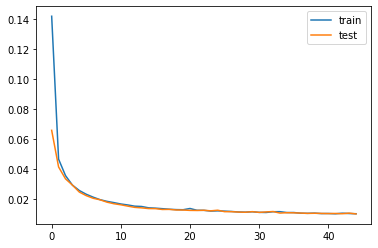

In [124]:
print(model1.evaluate(test_X, test_Y))

plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

## 這裡將測試集預測結果與原本的標籤進行比較

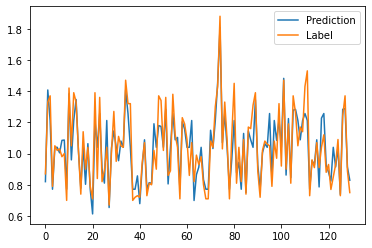

In [125]:
yhat1 = model1.predict(test_X)
plt.plot(yhat1, label='Prediction')
plt.plot(test_Y, label='Label')
plt.legend()
plt.show()

21/21 [==============================] - 0s 961us/step - loss: 0.0099 - mse: 0.0099
[0.00994963850826025, 0.00994963850826025]


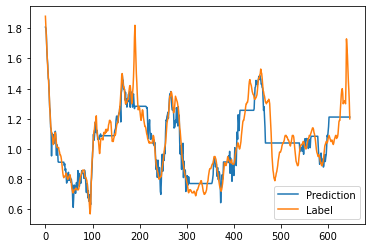

In [126]:
yhat11 = model1.predict(np.array(X))
print(model1.evaluate(np.array(X),np.array(Y)))
plt.plot(yhat11, label='Prediction')
plt.plot(Y, label='Label')
plt.legend()
plt.show()

# 使用 LSTM 建立預測系統

In [4]:
lr = 0.0002
epoch = 300
LSTM_unit = 32
tf.random.set_seed(0)
#
model2 = Sequential([LSTM(LSTM_unit, input_shape=(train_X.shape[1], train_X.shape[2])),
                     Dense(1)], name='Covid_Forecasting')

model2.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics=['mse'])

model2.summary()

Model: "Covid_Forecasting"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6912      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,945
Trainable params: 6,945
Non-trainable params: 0
_________________________________________________________________


In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history2 = model2.fit(train_X, train_Y, epochs=epoch, batch_size=64, validation_data=(test_X, test_Y), verbose=0, shuffle=True, callbacks=[callback])

5/5 [==============================] - 0s 3ms/step - loss: 0.0130 - mse: 0.0130
[0.013033007271587849, 0.013033007271587849]


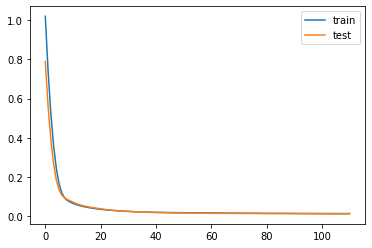

In [6]:
print(model2.evaluate(test_X, test_Y))

plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

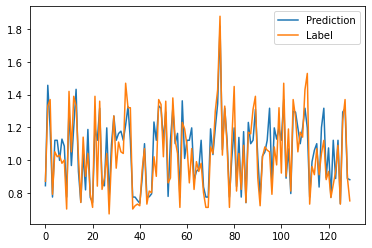

In [7]:
yhat2 = model2.predict(test_X)
plt.plot(yhat2, label='Prediction')
plt.plot(test_Y, label='Label')
plt.legend()
plt.show()

In [8]:
print('RMSE: {}'.format(sqrt(mean_squared_error(yhat2, test_Y))))
print('MSE: {}'.format(mean_squared_error(yhat2, test_Y)))
print('MAE: {}'.format(mean_absolute_error(yhat2, test_Y)))

RMSE: 0.11416219935148784
MSE: 0.013033007760768852
MAE: 0.08933276336009686


21/21 [==============================] - 0s 2ms/step - loss: 0.0134 - mse: 0.0134
[0.013439221307635307, 0.013439221307635307]


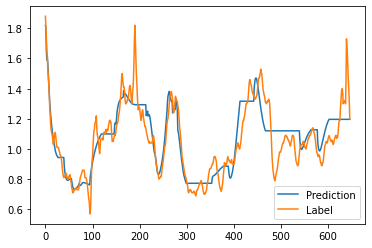

In [9]:
yhat3 = model2.predict(np.array(X))
print(model2.evaluate(np.array(X),np.array(Y)))
plt.plot(yhat3, label='Prediction')
plt.plot(Y, label='Label')
plt.legend()
plt.show()

In [11]:
log = model2.evaluate(np.array([test_X[0]]), np.array([test_Y[0]]), batch_size=1)

1/1 [==============================] - 0s 15ms/step - loss: 7.4934e-04 - mse: 7.4934e-04


In [12]:
print(log)

[0.0007493407465517521, 0.0007493407465517521]
